NOTES It can be the data set chosen to be the solution to PART I or a different one. Design the network:

--) Using critical thinking and the experiences of working with time-series datasets, the student should propose some changes to the above network (PART III) or the network training process, with which the network performance may be improved. Redesign the network

The student should decide the values of relevant parameters : 

1. Percentage of data for testing
2. How many layers of LSTM?
3. Number of neurons in each LSTM  layer?
4. Any DropOut layer? 
5. If with DropOut layer: the percentage to drop
6. Length of the time-series input sequence
7. Batch size for training (NOTES : Batch size for testing and forecasting must be ONE)
8. Number of epochs for training 

In [374]:
import pandas as pd
from pandas import read_csv
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')

In [375]:
from tensorflow.keras.models import Sequential
#sequential data reader

from tensorflow.keras.layers import LSTM
#Long short term memory

from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Dense
#Dense is a fully connected layer or FFNN(feedforward neural network).


In [376]:
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator
from sklearn.preprocessing import MinMaxScaler

### Data Set: Treasury interest yield (1/2/1990-12/30/2009)
https://www.treasury.gov/resource-center/data-chart-center/interest-rates/Pages/TextView.aspx?data=yieldAll

In [377]:
df_all = pd.read_csv("1990.csv")
df_all.tail(5)
#Adj close = the closing price excluded dividend and split effect

,Date,1 Mo,2 Mo,3 Mo,6 Mo,1 Yr,2 Yr,3 Yr,5 Yr,7 Yr,10 Yr,20 Yr,30 Yr
4999,12/24/2009,0.02,NaN,0.05,0.18,0.43,1.00,1.56,2.57,3.32,3.82,4.60,4.68
5000,12/28/2009,0.03,NaN,0.11,0.20,0.47,1.09,1.63,2.62,3.34,3.85,4.61,4.69
5001,12/29/2009,0.02,NaN,0.10,0.20,0.47,1.09,1.64,2.62,3.33,3.82,4.57,4.64
5002,12/30/2009,0.02,NaN,0.05,0.19,0.45,1.08,1.65,2.61,3.34,3.80,4.54,4.61
5003,12/31/2009,0.04,NaN,0.06,0.20,0.47,1.14,1.70,2.69,3.39,3.85,4.58,4.63


In [378]:
df_all.shape

(5004, 13)

In [379]:
df_all.dtypes

Date      object
1 Mo     float64
2 Mo     float64
3 Mo     float64
6 Mo     float64
1 Yr     float64
2 Yr     float64
3 Yr     float64
5 Yr     float64
7 Yr     float64
10 Yr    float64
20 Yr    float64
30 Yr    float64
dtype: object

In [380]:
df_all.describe()

,1 Mo,2 Mo,3 Mo,6 Mo,1 Yr,2 Yr,3 Yr,5 Yr,7 Yr,10 Yr,20 Yr,30 Yr
count,2105.000000,0.0,5001.000000,5004.000000,5004.000000,5004.000000,5004.000000,5004.000000,5004.000000,5004.000000,4065.000000,4010.000000
mean,2.198304,NaN,3.881428,4.040923,4.187534,4.537030,4.754820,5.120602,5.384616,5.562682,5.646809,6.224519
std,1.618567,NaN,1.967405,1.974862,1.936733,1.895358,1.804245,1.644626,1.549959,1.447799,1.027790,1.341930
min,0.000000,NaN,0.010000,0.130000,0.260000,0.650000,0.880000,1.260000,1.590000,2.080000,2.860000,2.530000
25%,0.950000,NaN,2.210000,2.290000,2.547500,3.120000,3.460000,3.910000,4.150000,4.410000,4.840000,5.180000
50%,1.730000,NaN,4.440000,4.560000,4.650000,4.750000,4.805000,5.100000,5.390000,5.440000,5.520000,6.130000
75%,3.520000,NaN,5.200000,5.360000,5.560000,5.910000,6.040000,6.280000,6.450000,6.560000,6.420000,7.310000
max,5.270000,NaN,8.260000,8.490000,8.640000,9.050000,9.110000,9.100000,9.120000,9.090000,8.300000,9.180000


### Keep Only 1 Year Treasury bond yield and Filter Our All Other Attributes
This project focus on the 1 year treasury bond yield because this dataset has no na.

In [381]:
df = df_all.iloc[:,5:6]
# this will take only 1Yr to store at df
df.head()

,1 Yr
0,7.81
1,7.85
2,7.82
3,7.79
4,7.81


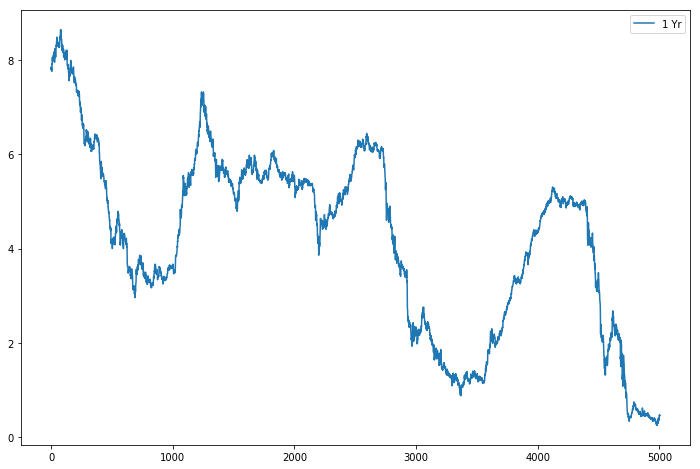

In [382]:
df.plot(figsize=(12,8))

### Lenght of Input Time Series - Number of input Time Steps

In [383]:
#Set the Lenght of the input sequence
length60 = 60

### Time series Dataset: Train/ test split

In [384]:
len(df)

5004

In [385]:
# set percentage of data used for testing
test_percent = 0.1
#10% of dataset isfor testing

In [386]:
test_length = np.round(len(df)*test_percent)
test_length
#The test data points is 

500.0

In [387]:
#testing dataset starts at the index
split_index = int(len(df)-test_length)
split_index

4504

In [388]:
data_train = df.iloc[:split_index]
data_test = df.iloc[split_index - length60 :]
#the last 60 data of the training dataset until the end of the data to test the model

In [389]:
data_train.head(5)

,1 Yr
0,7.81
1,7.85
2,7.82
3,7.79
4,7.81


In [390]:
data_test.head(5)
#4504 - 60 -1 =  4443

,1 Yr
4444,4.10
4445,4.16
4446,4.23
4447,4.23
4448,4.22


### Normaliza Data(Scale it into the range [0,1])

In [391]:
scaler = MinMaxScaler()
scaler.fit(data_train)
normalized_train = scaler.transform(data_train)
normalized_test = scaler.transform(data_test)
#transform the value in normal[0,1]

### Create TimeseriesGenerate for Training

In [392]:
#Time series has 60 historical data point
batch_size32 = 32


train_tsGenerator60 = TimeseriesGenerator(normalized_train, normalized_train, length60, batch_size = batch_size32)
#TimeseriesGenerator(input,outputs, length, batch_size)


In [393]:
#This project generate  times 4504 - 60 -1 = 4443 
len(normalized_train)

4504

In [394]:
len(train_tsGenerator60)
#batch generated by time series generator from 4503
#last that left from generate sequnce processes
#This project generate 4443 times = 4503 - 60
# 4443/32 each batch has 139 samples

139

In [395]:
X,y = train_tsGenerator60[0]
print(X)

[[[0.89304124]
  [0.89819588]
  [0.8943299 ]
  ...
  [0.95618557]
  [0.96262887]
  [0.96005155]]

 [[0.89819588]
  [0.8943299 ]
  [0.89046392]
  ...
  [0.96262887]
  [0.96005155]
  [0.96391753]]

 [[0.8943299 ]
  [0.89046392]
  [0.89304124]
  ...
  [0.96005155]
  [0.96391753]
  [0.96262887]]

 ...

 [[0.91108247]
  [0.92139175]
  [0.93170103]
  ...
  [0.9742268 ]
  [0.96907216]
  [0.96907216]]

 [[0.92139175]
  [0.93170103]
  [0.92912371]
  ...
  [0.96907216]
  [0.96907216]
  [0.96005155]]

 [[0.93170103]
  [0.92912371]
  [0.94845361]
  ...
  [0.96907216]
  [0.96005155]
  [0.94458763]]]


### Build Train and Test

In [396]:
n_features = 1
#feature has 1 preditor

In [397]:
#define the model
model = Sequential()

model.add(LSTM(units=60, activation='relu',return_sequences=True, input_shape=(length60,n_features)))
#return_sequences=True will return the value to next LSTM layer
#input_shape=(length60,n_features) = input demension is 2 demensions.
model.add(Dropout(0.25))
#dropout 25% of the all data

model.add(LSTM(units=60, activation='relu',return_sequences=True))
#learning funciton to fullfill the dropped data.
#return_sequences=True will return the value to next LSTM layer
model.add(Dropout(0.25))

model.add(LSTM(units=60, activation='relu',return_sequences=True))
#learning funciton to fullfill the dropped data.
#return_sequences=True will return the value to next LSTM layer
model.add(Dropout(0.25))

model.add(LSTM(units=60, activation='relu'))
#learning funciton to fullfill the dropped data.

model.add(Dense(1))

### Complie model

In [398]:
model.compile(optimizer = 'adam', loss ='mse')
#complie Adaptive Moment Estimation (adam) and loss function to monitor the model

model.summary()
#summmarize the model

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_18 (LSTM)               (None, 60, 60)            14880     
_________________________________________________________________
dropout_12 (Dropout)         (None, 60, 60)            0         
_________________________________________________________________
lstm_19 (LSTM)               (None, 60, 60)            29040     
_________________________________________________________________
dropout_13 (Dropout)         (None, 60, 60)            0         
_________________________________________________________________
lstm_20 (LSTM)               (None, 60, 60)            29040     
_________________________________________________________________
dropout_14 (Dropout)         (None, 60, 60)            0         
_________________________________________________________________
lstm_21 (LSTM)               (None, 60)               

### Train(Fit) model Using fit_generator()

In [399]:
model.fit_generator(train_tsGenerator60, epochs=50)

Epoch 1/50
139/139 [==============================] - 44s 314ms/step - loss: 0.0358
Epoch 2/50
139/139 [==============================] - 34s 244ms/step - loss: 0.0057
Epoch 3/50
139/139 [==============================] - 34s 243ms/step - loss: 0.0023
Epoch 4/50
139/139 [==============================] - 34s 248ms/step - loss: 0.0019
Epoch 5/50
139/139 [==============================] - 35s 250ms/step - loss: 0.0015
Epoch 6/50
139/139 [==============================] - 34s 246ms/step - loss: 0.0016
Epoch 7/50
139/139 [==============================] - 34s 247ms/step - loss: 0.0015
Epoch 8/50
139/139 [==============================] - 34s 243ms/step - loss: 0.0019
Epoch 9/50
139/139 [==============================] - 34s 242ms/step - loss: 0.0014
Epoch 10/50
139/139 [==============================] - 33s 239ms/step - loss: 0.0015
Epoch 11/50
139/139 [==============================] - 34s 242ms/step - loss: 0.0014
Epoch 12/50
139/139 [==============================] - 34s 245ms/step - lo

### Visualize the model

In [400]:
loss_history_keys = model.history.history.keys()

loss_history_keys

dict_keys(['loss'])

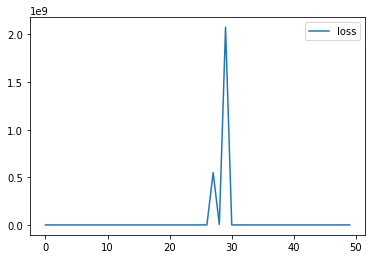

In [401]:
df_model_loss = pd.DataFrame(model.history.history)

df_model_loss.plot()

### prediction for Testing: Using TimeseriesGenerator

In [402]:
batch_size1 =1 
# In a timeserise batch has 1 dataset

test_tsGenerator60 = TimeseriesGenerator(normalized_test, normalized_test, length=length60, batch_size = batch_size1)
#TimeseriesGenerator(input,outputs, length, batch_size)

### Predict Future Data Points for Testing
### Create TimeriesGenerator for Testing

In [403]:
normalized_prediction = model.predict_generator(test_tsGenerator60)
# predict the time series
normalized_prediction
#500 data point (predicted value)

array([[0.21844035],
       [0.21777451],
       [0.21711186],
       [0.21643987],
       [0.21576288],
       [0.215078  ],
       [0.21437727],
       [0.21365176],
       [0.21290562],
       [0.21214068],
       [0.2113466 ],
       [0.2105206 ],
       [0.20964257],
       [0.2086766 ],
       [0.20758335],
       [0.20636027],
       [0.20502552],
       [0.20360197],
       [0.20211905],
       [0.20058984],
       [0.1990359 ],
       [0.19746616],
       [0.19587168],
       [0.19426358],
       [0.19263825],
       [0.19101423],
       [0.18940127],
       [0.18779957],
       [0.18622756],
       [0.18470201],
       [0.18322419],
       [0.18178314],
       [0.18036565],
       [0.17901327],
       [0.17772815],
       [0.17655843],
       [0.17550796],
       [0.17456362],
       [0.17371133],
       [0.17292221],
       [0.17217165],
       [0.17143112],
       [0.17068106],
       [0.16991398],
       [0.16912247],
       [0.16830067],
       [0.16744734],
       [0.166

In [404]:
len(normalized_prediction)

500

In [414]:
prediction = scaler.inverse_transform(normalized_prediction)
#convert the predicted value to be true value
prediction_index =np.arange(4504,5004,step=1)
#4442 data poiints + 501 data points in the testing data = 5003 data points

df_prediction = pd.DataFrame(data = prediction, index=prediction_index, columns=['Prediction'])
#index will predict from 4443 to 5003
df_prediction

,Prediction
4504,2.575097
4505,2.569930
4506,2.564788
4507,2.559573
4508,2.554320
...,...
4999,1.925983
5000,1.926298
5001,1.926647
5002,1.927033


### Visualization

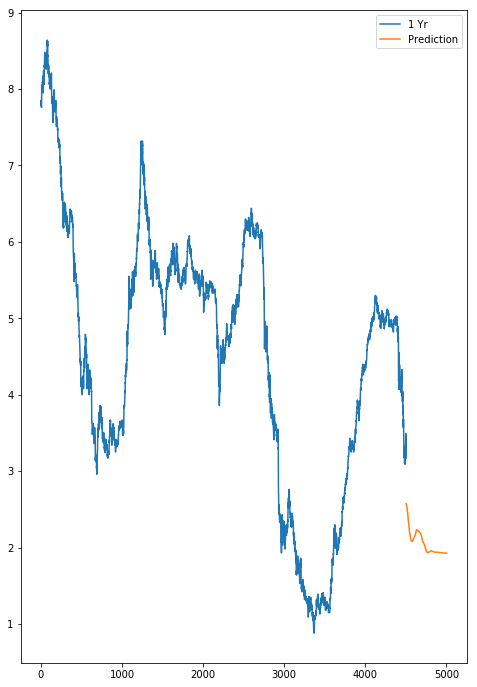

In [415]:
ax = data_train.plot()

df_prediction.plot(ax=ax, figsize=(8,12))
# orange is predicted value
#blue is real value that train the dataset

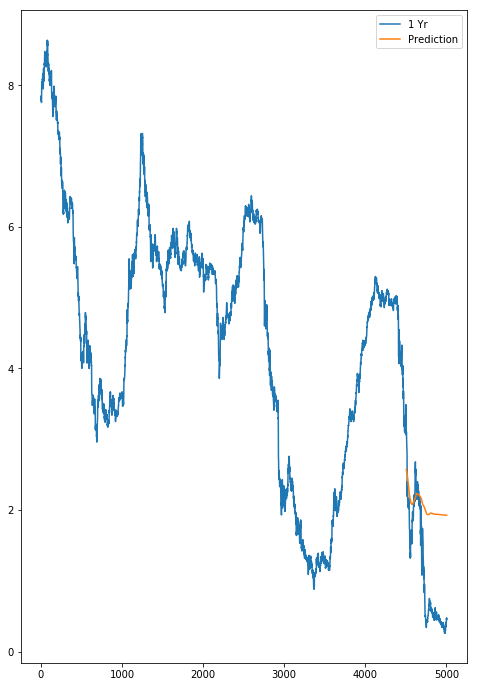

In [416]:
ax = df.plot()

df_prediction.plot(ax=ax, figsize=(8,12))
# orange is predicted value
#blue is real value

## Time Series Forecasting with LSTM
forecast the future should employ all the avaliable data Not split the data into training/testing

### Preprocesses Full Input Dataset

In [417]:
full_scaler = MinMaxScaler()
normalized_full_data = full_scaler.fit_transform(df)

### Create TimeSeriesGenerator for Forecasting

In [418]:
length60

60

In [419]:
# the batch =32
forecast_tsGenerator = TimeseriesGenerator(normalized_full_data, normalized_full_data, length = length60, batch_size = batch_size32)

### Build, Complie, and Fit LSTM Model for Forecasting

In [420]:
model.fit_generator(forecast_tsGenerator, epochs = 20)

Epoch 1/20
155/155 [==============================] - 41s 262ms/step - loss: 25.3086
Epoch 2/20
155/155 [==============================] - 41s 262ms/step - loss: 25.5920
Epoch 3/20
155/155 [==============================] - 41s 263ms/step - loss: 50.4931
Epoch 4/20
155/155 [==============================] - 43s 275ms/step - loss: 18.3406
Epoch 5/20
155/155 [==============================] - 42s 273ms/step - loss: 20.8888
Epoch 6/20
155/155 [==============================] - 41s 266ms/step - loss: 38.7746
Epoch 7/20
155/155 [==============================] - 42s 268ms/step - loss: 34.9083
Epoch 8/20
155/155 [==============================] - 40s 258ms/step - loss: 31.4243
Epoch 9/20
155/155 [==============================] - 41s 267ms/step - loss: 32.5808
Epoch 10/20
155/155 [==============================] - 41s 266ms/step - loss: 21.6696
Epoch 11/20
155/155 [==============================] - 41s 267ms/step - loss: 21.5806
Epoch 12/20
155/155 [==============================] - 41s 267m

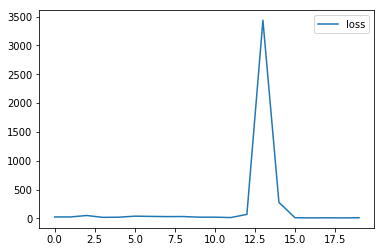

In [421]:
loss_history_keys = model.history.history.keys()

loss_history_keys
df_model_loss = pd.DataFrame(model.history.history)

df_model_loss.plot()

### Time Series Forecasting with LSTM Neural Network: (1/4/2010-12/31/2010)

In [422]:
forecast = []
periods = 252
# days business days (1/4/2010-12/31/2010)

first_eval_batch = normalized_full_data[-length60:]
current_batch = first_eval_batch.reshape((1,length60,n_features))
#The last 60 dataset is the first batch

for i in range(periods):
    #get prediction 1 time stamp ahead ([0] is for grabbing just the number instead of [array])
    current_pred = model.predict(current_batch)[0]
    
    #store prediction
    forecast.append(current_pred)
    
    current_batch = np.append(current_batch[:,1:,:],[[current_pred]], axis=1)

### Invese to Transform Normalized Data Back into True Values

In [423]:
forecast = full_scaler.inverse_transform(forecast)
forecast

array([[1.29505204],
       [1.29600937],
       [1.29750639],
       [1.29967754],
       [1.3025489 ],
       [1.30608096],
       [1.31016077],
       [1.3146353 ],
       [1.31935395],
       [1.32418311],
       [1.32892137],
       [1.3334446 ],
       [1.33768886],
       [1.34162869],
       [1.34526321],
       [1.34860003],
       [1.3516474 ],
       [1.35441681],
       [1.35692423],
       [1.35917504],
       [1.36117736],
       [1.36295579],
       [1.36453104],
       [1.36592548],
       [1.36716159],
       [1.36825946],
       [1.36923671],
       [1.37010844],
       [1.37088714],
       [1.37158392],
       [1.37221428],
       [1.37278694],
       [1.37330753],
       [1.37377942],
       [1.37420648],
       [1.37459208],
       [1.37493973],
       [1.37525265],
       [1.37553387],
       [1.37578648],
       [1.376013  ],
       [1.37621591],
       [1.37639748],
       [1.37656069],
       [1.37670716],
       [1.37683828],
       [1.3769559 ],
       [1.377

In [424]:
df

,1 Yr
0,7.81
1,7.85
2,7.82
3,7.79
4,7.81
...,...
4999,0.43
5000,0.47
5001,0.47
5002,0.45


### Create new timestamp index with pandas:07/01/20-12/15/2019

In [425]:
forecast_index = np.arange(5004,5255, step=1)

In [426]:
forecast_df = pd.DataFrame(data=forecast, index = forecast_index, columns=['Forecast'])
forecast_df

,Forecast
5004,1.295052
5005,1.296009
5006,1.297506
5007,1.299678
5008,1.302549
...,...
5251,1.377888
5252,1.377888
5253,1.377888
5254,1.377888


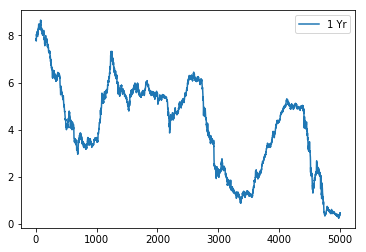

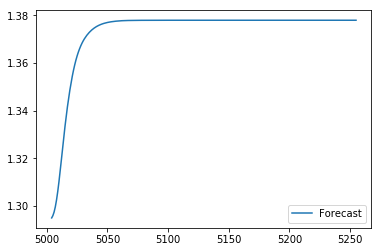

In [427]:
df.plot()
forecast_df.plot()

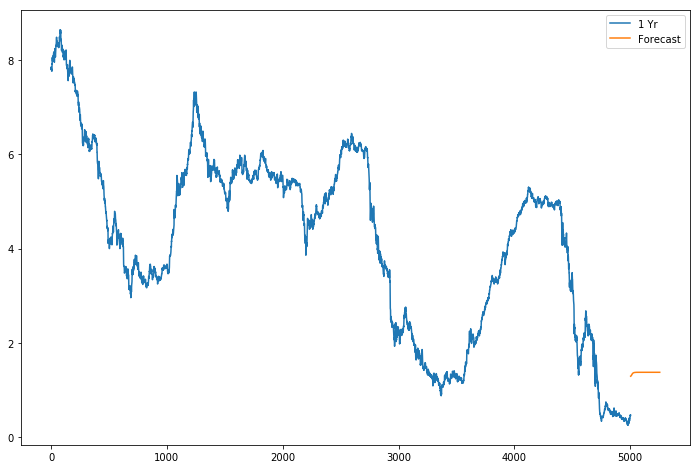

In [428]:
ax = df.plot()
forecast_df.plot(ax = ax, figsize=(12,8))

In [429]:
dir_path_dataset_2 = 'prediction.csv'

In [430]:
df_all_predicting = pd.read_csv(dir_path_dataset_2)

In [431]:
df_all_predicting.head()

,Date,1 Mo,2 Mo,3 Mo,6 Mo,1 Yr,2 Yr,3 Yr,5 Yr,7 Yr,10 Yr,20 Yr,30 Yr
0,1/4/2010,0.05,NaN,0.08,0.18,0.45,1.09,1.66,2.65,3.36,3.85,4.60,4.65
1,1/5/2010,0.03,NaN,0.07,0.17,0.41,1.01,1.57,2.56,3.28,3.77,4.54,4.59
2,1/6/2010,0.03,NaN,0.06,0.15,0.40,1.01,1.60,2.60,3.33,3.85,4.63,4.70
3,1/7/2010,0.02,NaN,0.05,0.16,0.40,1.03,1.62,2.62,3.33,3.85,4.62,4.69
4,1/8/2010,0.02,NaN,0.05,0.15,0.37,0.96,1.56,2.57,3.31,3.83,4.61,4.70


In [432]:
df_all_predicting = df_all_predicting.iloc[:,5:6]

In [433]:
df_all_predicting

,1 Yr
0,0.45
1,0.41
2,0.40
3,0.40
4,0.37
...,...
247,0.32
248,0.31
249,0.30
250,0.29


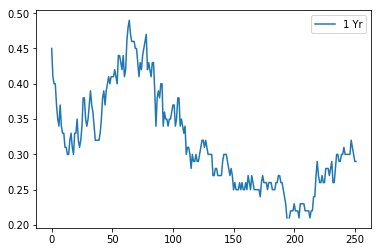

In [434]:
df_all_predicting.plot()

In [435]:
forecast_df['Forecast'].values

array([1.29505204, 1.29600937, 1.29750639, 1.29967754, 1.3025489 ,
       1.30608096, 1.31016077, 1.3146353 , 1.31935395, 1.32418311,
       1.32892137, 1.3334446 , 1.33768886, 1.34162869, 1.34526321,
       1.34860003, 1.3516474 , 1.35441681, 1.35692423, 1.35917504,
       1.36117736, 1.36295579, 1.36453104, 1.36592548, 1.36716159,
       1.36825946, 1.36923671, 1.37010844, 1.37088714, 1.37158392,
       1.37221428, 1.37278694, 1.37330753, 1.37377942, 1.37420648,
       1.37459208, 1.37493973, 1.37525265, 1.37553387, 1.37578648,
       1.376013  , 1.37621591, 1.37639748, 1.37656069, 1.37670716,
       1.37683828, 1.3769559 , 1.37706092, 1.37715483, 1.37723886,
       1.37731441, 1.37738234, 1.37744315, 1.37749735, 1.37754567,
       1.37758925, 1.37762784, 1.37766218, 1.37769302, 1.37772062,
       1.37774522, 1.37775983, 1.37777319, 1.3777853 , 1.37779617,
       1.37780603, 1.37781477, 1.37782276, 1.37782988, 1.37783637,
       1.37784199, 1.37784724, 1.37785173, 1.37785585, 1.37785

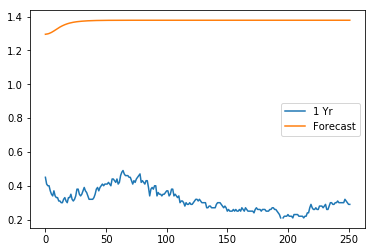

In [436]:
df_all_predicting['Forecast'] = forecast_df['Forecast'].values
df_all_predicting.plot()